## Treatment T10 Preparation

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

RND_SEED = 6
np.random.seed(RND_SEED)

# DATA_FILE = "../data/t00/data_gen.csv"

TREATMENT = "t00"

# Read and sanitize the data
export_folder = f"../data/output/diagrams/dss"
os.makedirs(export_folder, exist_ok=True)


df = pd.read_csv(f"../data/{TREATMENT}/export/result__{TREATMENT}_prop.csv")
df_full = df.copy()
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status",
             "timestamp", "rowid", "offer_dss", "offer", "offer_final", "completion_code", "prop_time_spent", "worker_bonus"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()

cols = [col for col in df.columns if col != "min_offer"] + ["min_offer"]
df = df[cols]

## comment/uncomment for shuffling
# df = df.sample(frac=1.0)
# TEST_SIZE = int((df.shape[0]) * 0.4)
# df_base = df.copy()

# df_train = df.head(df.shape[0] - TEST_SIZE)
# df_test = df.tail(TEST_SIZE)


df_min = df_full.min()
df_max = df_full.max()
df.head()

,cc_beta,cc_criterion,cc_false_alarm_avg_click_delay,cc_false_alarm_rate,cc_false_alarms,cc_hit_avg_click_delay,cc_hit_rate,cc_hits,cc_sensitivity,cpc_expected_value,...,ras_q9,ras_time_spent,resp_time_spent,risk_expected_value,risk_q1,risk_q2,risk_q3,risk_q4,risk_time_spent,min_offer
0,0.786247,-0.146466,271.0,0.25,1,290.00,0.833333,5,1.641911,9.5323,...,-1,115,11,3.0125,1.05,1.50,3.50,6.00,52,40
1,0.744767,1.266672,0.0,0.00,0,0.00,0.000000,0,-0.232645,9.5323,...,-2,227,12,1.8200,1.04,1.20,2.00,3.04,62,50
2,1.766303,0.359811,0.0,0.00,0,362.75,0.666667,4,1.581077,10.6715,...,2,95,21,1.8200,1.04,1.20,2.00,3.04,39,40
3,0.626283,-0.483711,205.0,0.50,2,232.00,0.833333,5,0.967422,10.2117,...,2,153,8,4.6450,1.09,1.99,5.50,10.00,101,50
4,1.766303,0.790538,0.0,0.00,0,420.00,0.333333,2,0.719622,8.6673,...,3,107,9,2.0350,1.02,1.60,1.53,3.99,18,50


In [2]:
set(df.columns) - set(['cc_beta', 'cc_criterion', 'cc_false_alarm_avg_click_delay', 'cc_false_alarm_rate', 'cc_false_alarms', 'cc_hit_avg_click_delay', 'cc_hit_rate', 'cc_hits', 'cc_sensitivity', 'cpc_expected_value', 'cpc_expected_value_max', 'cpc_expected_value_min', 'cpc_q1', 'cpc_q10', 'cpc_q2', 'cpc_q3', 'cpc_q4', 'cpc_q5', 'cpc_q6', 'cpc_q7', 'cpc_q8', 'cpc_q9', 'cpc_time_spent', 'exp_ultimatum_game_experience', 'ras_assertiveness', 'ras_q1', 'ras_q10', 'ras_q11', 'ras_q12', 'ras_q13', 'ras_q14', 'ras_q15', 'ras_q16', 'ras_q17', 'ras_q18', 'ras_q19', 'ras_q2', 'ras_q20', 'ras_q21', 'ras_q22', 'ras_q23', 'ras_q24', 'ras_q25', 'ras_q26', 'ras_q27', 'ras_q28', 'ras_q29', 'ras_q3', 'ras_q30', 'ras_q4', 'ras_q5', 'ras_q6', 'ras_q7', 'ras_q8', 'ras_q9', 'ras_time_spent', 'risk_expected_value', 'risk_q1', 'risk_q2', 'risk_q3', 'risk_q4', 'risk_time_spent', 'resp_time_spent'])

{'min_offer'}

## Determine significant features

**Feature importance permutation**

In [3]:
from core.utils.preprocessing import df_to_xy, df_to_xydf
from core.models import AcceptanceModel, ClusterExtModel
from core.models.metrics import MAX_GAIN
from core.utils.benchmark import process_model, process_benchmark_cv
from mlxtend.evaluate import feature_importance_permutation



## DSS Model

**Save the model and model infos**

In [4]:
from core.utils.pipeline import train_and_save
from sklearn.svm import SVR, LinearSVR
from core.models import EMModel
model = EMModel()

top_model, infos = train_and_save("../data/t00/export", "../data/t00", model=model, shuffle=True, random_state=RND_SEED, top_columns=[], data_dir_filename=f"data__{TREATMENT}_prop.csv", drop_columns=drop_cols)
print("acc:", infos["acc"], "val_acc:", infos["val_acc"], "unique_values:", (infos["unique_preds"]))

acc: 0.8212135502804325 val_acc: 0.7879122409197598 unique_values: [50.0]


In [5]:
# from core.utils.explanation import get_acceptance_probability
# offers = list(range(0, MAX_GAIN+5, 5))
# m = np.zeros((len(offers)))
# for idx, offer in enumerate(offers):
#     m[idx] = get_acceptance_probability(0, offer, infos["acc"], infos["train_err_pdf"], experiment_mode=True, train_pdf=infos["pdf"])

# p_accepted = m
# df = pd.DataFrame(data={"offer": offers, "p_best_offer": p_accepted})
# ax = df.plot(x="offer", y="p_best_offer")

# ax.figure.savefig(os.path.join(export_folder, "min_offer_offer.png"))


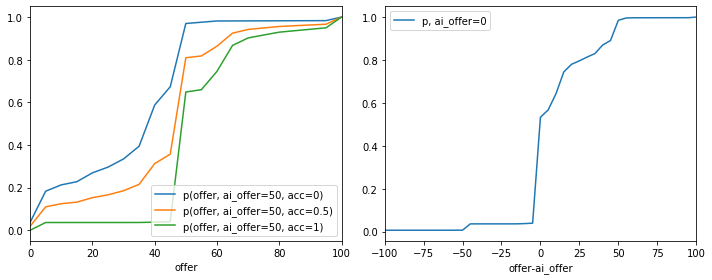

In [33]:
from core.utils.explanation import get_acceptance_probability
offers = list(range(0, MAX_GAIN+5, 5))
p_accepted_0 = np.zeros((len(offers)))
p_accepted_1 = np.zeros((len(offers)))
p_accepted_05 = np.zeros((len(offers)))

AI_OFFER = 50

for idx, offer in enumerate(offers):
    p_accepted_0[idx] = get_acceptance_probability(AI_OFFER, offer, 0, infos["train_err_pdf"], experiment_mode=True, train_pdf=infos["pdf"])
    p_accepted_1[idx] = get_acceptance_probability(AI_OFFER, offer, 1, infos["train_err_pdf"], experiment_mode=True, train_pdf=infos["pdf"])
    p_accepted_05[idx] = get_acceptance_probability(AI_OFFER, offer, 0.5, infos["train_err_pdf"], experiment_mode=True, train_pdf=infos["pdf"])

lbl0 = f"p(offer, ai_offer={AI_OFFER}, acc=0)"
lbl1 = f"p(offer, ai_offer={AI_OFFER}, acc=1)"
lbl05 = f"p(offer, ai_offer={AI_OFFER}, acc=0.5)"


f, axes = plt.subplots(1, 2, figsize=(10,4))

df1 = pd.DataFrame(data={"offer": offers, lbl0: p_accepted_0, lbl1: p_accepted_1, lbl05: p_accepted_05})
ax = df1.plot(x="offer", y=[lbl0, lbl05, lbl1], ax=axes[0])


errors = list(range(-MAX_GAIN, MAX_GAIN+5, 5))
p_accepted = np.zeros_like(errors, dtype=float)

for idx, offer in enumerate(errors):
    p_accepted[idx] = get_acceptance_probability(0, offer, infos['acc'], infos["train_err_pdf"], experiment_mode=True, train_pdf=infos["pdf"])

lbl = "p, ai_offer=0"
df2 = pd.DataFrame(data={"offer-ai_offer": infos["bins_train_err_pdf"][:-1], lbl: p_accepted})
ax = df2.plot(x="offer-ai_offer", y=lbl, ax=axes[1])
plt.tight_layout()

ax.figure.savefig(os.path.join(export_folder, "p_accepted.pdf"))

In [7]:
# from core.utils.explanation import get_best_offer_probability
# errors = list(range(-MAX_GAIN, MAX_GAIN+5, 5))
# p_best_offer = np.zeros_like(errors, dtype=float)

# for idx, offer in enumerate(errors):
#     p_best_offer[idx] = get_best_offer_probability(0, offer, infos['acc'], infos["train_err_pdf"], experiment_mode=True)
# #     (ai_offer=ai_offer, offer=offer, accuracy=model_infos["acc"], train_err_pdf=model_infos["train_err_pdf"])

# df = pd.DataFrame(data={"offer-ai_offer": infos["bins_train_err_pdf"][:-1], "p": p_best_offer})
# ax = df.plot(x="offer-ai_offer", y="p")

# plt.tight_layout()
# ax.figure.savefig(os.path.join(export_folder, "p_best_offer.pdf"))

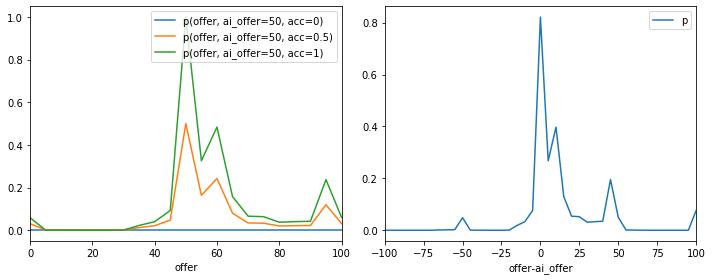

In [9]:
from core.utils.explanation import get_best_offer_probability
offers = list(range(0, MAX_GAIN+5, 5))
p_best_offer_0 = np.zeros((len(offers)))
p_best_offer_1 = np.zeros((len(offers)))
p_best_offer_05 = np.zeros((len(offers)))

AI_OFFER = 50
for idx, offer in enumerate(offers):
    p_best_offer_0[idx] = get_best_offer_probability(AI_OFFER, offer, 0, infos["train_err_pdf"], experiment_mode=True)
    p_best_offer_1[idx] = get_best_offer_probability(AI_OFFER, offer, 1, infos["train_err_pdf"], experiment_mode=True)
    p_best_offer_05[idx] = get_best_offer_probability(AI_OFFER, offer, 0.5, infos["train_err_pdf"], experiment_mode=True)

lbl0 = f"p(offer, ai_offer={AI_OFFER}, acc=0)"
lbl1 = f"p(offer, ai_offer={AI_OFFER}, acc=1)"
lbl05 = f"p(offer, ai_offer={AI_OFFER}, acc=0.5)"


f, axes = plt.subplots(1, 2, figsize=(10,4))

df1 = pd.DataFrame(data={"offer": offers, lbl0: p_best_offer_0, lbl1: p_best_offer_1, lbl05: p_best_offer_05})
ax = df1.plot(x="offer", y=[lbl0, lbl05, lbl1], ax=axes[0])


errors = list(range(-MAX_GAIN, MAX_GAIN+5, 5))
p_best_offer = np.zeros_like(errors, dtype=float)

for idx, offer in enumerate(errors):
    p_best_offer[idx] = get_best_offer_probability(0, offer, infos['acc'], infos["train_err_pdf"], experiment_mode=True)

lbl = "p"
df2 = pd.DataFrame(data={"offer-ai_offer": infos["bins_train_err_pdf"][:-1], lbl: p_best_offer})
ax = df2.plot(x="offer-ai_offer", y=lbl, ax=axes[1])
plt.tight_layout()

ax.figure.savefig(os.path.join(export_folder, "p_best_offer.pdf"))

In [ ]:
# p_best_offer = np.convolve(infos["train_err_pdf"], [0.02, 0.03, 0.04, 0.9, 0.005, 0.003, 0.002], "same")
# p_best_offer *= infos["acc"] / p_best_offer.max()
# df = pd.DataFrame(data={"offer-ai_offer": infos["bins_train_err_pdf"][:-1], "p_best_offer": p_best_offer})
# ax = df.plot(x="offer-ai_offer", y="p_best_offer")

# ax.figure.savefig(os.path.join(export_folder, "p_best_offer.pdf"))

In [ ]:
# p_best_offer = np.convolve(infos["train_err_pdf"], [0.02, 0.03, 0.04, 0.9, 0.005, 0.003, 0.002])
p_best_offer_raw = np.array(infos["train_err_pdf"])
p_best_offer_raw *= (infos["acc"] * 1.0) / p_best_offer_raw.max()
df = pd.DataFrame(data={"offer-ai_offer": infos["bins_train_err_pdf"][:-1], "p_best_offer": p_best_offer - p_best_offer_raw})
df.plot(x="offer-ai_offer", y="p_best_offer")